In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib
from joblib import dump, load

def preprocess_data(df, target_column):
    df = df.dropna()
    
    label_encoders = {}
    label_mapping = {}
    target_encoder = LabelEncoder()
    
    # Encode categorical features
    for column in df.select_dtypes(include=['object']).columns:
        if column != target_column:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le

    # Encode target variable
    df[target_column] = target_encoder.fit_transform(df[target_column])
    label_encoders[target_column] = target_encoder  # Save the target encoder

    # Save the label encoders and target mapping
    joblib.dump(label_encoders, 'label_encoders.joblib')
    label_mapping = dict(enumerate(target_encoder.classes_))
    joblib.dump(label_mapping, 'label_mapping.joblib')

    X = df.drop(columns=[target_column])
    y = df[target_column]

    return X, y, label_encoders, label_mapping
    

# Function to train a model
def train_model(X, y, model, param_grid=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Hyperparameter tuning (GridSearchCV used) (Not typically used for Naive Bayes)
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline

    # Evaluate the model
    y_pred = best_model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

    return best_model

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


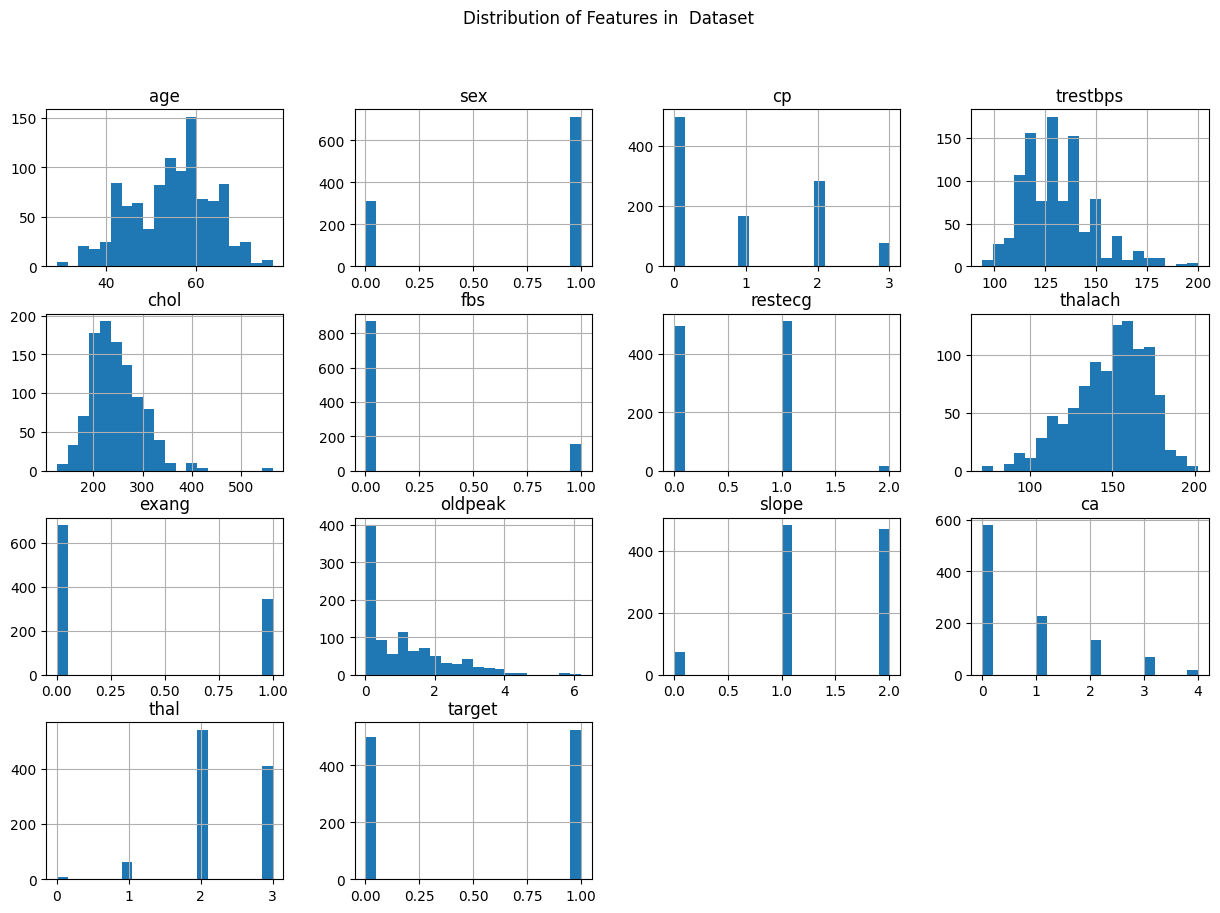

In [2]:
df = pd.read_csv('heart.csv')
print(df.head())
X, y, encoders, label_mapping = preprocess_data(df, 'target')

df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Features in  Dataset")
plt.show()

In [3]:
df.shape

(1025, 14)

In [4]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


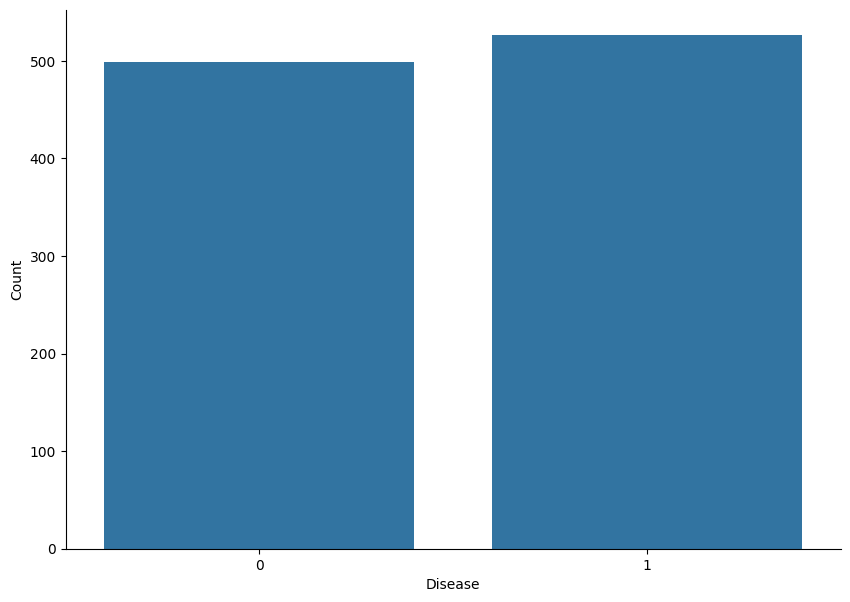

In [10]:
plt.figure(figsize=(10,7))
sns.countplot(x='target', data = df)

# Removing the unwanted spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Headings
plt.xlabel('Disease')
plt.ylabel('Count')

plt.show()

In [11]:
#Naive-Bias Model
model = GaussianNB()

best_model = train_model(X, y, model)

# Save the trained model
dump(best_model, 'best_model_naive_bayes.joblib')

Confusion Matrix:
 [[72 30]
 [11 92]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78       102
           1       0.75      0.89      0.82       103

    accuracy                           0.80       205
   macro avg       0.81      0.80      0.80       205
weighted avg       0.81      0.80      0.80       205

Accuracy Score: 0.8


['best_model_naive_bayes.joblib']

In [12]:
#SVM Model
model = SVC()

best_model = train_model(X, y, model)

dump(best_model, 'best_model_svm.joblib')

Confusion Matrix:
 [[85 17]
 [ 6 97]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       102
           1       0.85      0.94      0.89       103

    accuracy                           0.89       205
   macro avg       0.89      0.89      0.89       205
weighted avg       0.89      0.89      0.89       205

Accuracy Score: 0.8878048780487805


['best_model_svm.joblib']

In [13]:
#Random Forest Model
model = RandomForestClassifier()

# parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

best_model = train_model(X, y, model, param_grid)

dump(best_model, 'best_model_random_forest.joblib')

Confusion Matrix:
 [[102   0]
 [  3 100]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Accuracy Score: 0.9853658536585366


['best_model_random_forest.joblib']

In [14]:
#Decision Tree Model
model = DecisionTreeClassifier()

param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

best_model = train_model(X, y, model, param_grid)

dump(best_model, 'best_model_decision_tree_diabetes.joblib')

Confusion Matrix:
 [[102   0]
 [  3 100]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Accuracy Score: 0.9853658536585366


['best_model_decision_tree_diabetes.joblib']

In [15]:
#K-Nearest Neighbour
model = KNeighborsClassifier()

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

best_model = train_model(X, y, model, param_grid)

dump(best_model, 'best_model_knn_diabetes.joblib')

Confusion Matrix:
 [[94  8]
 [ 5 98]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       102
           1       0.92      0.95      0.94       103

    accuracy                           0.94       205
   macro avg       0.94      0.94      0.94       205
weighted avg       0.94      0.94      0.94       205

Accuracy Score: 0.9365853658536586


['best_model_knn_diabetes.joblib']

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  Predictions  
0   2     3            0  
1   0     3            0  
2   0     3            0  
3   1     3            1  
4   3     2            0  


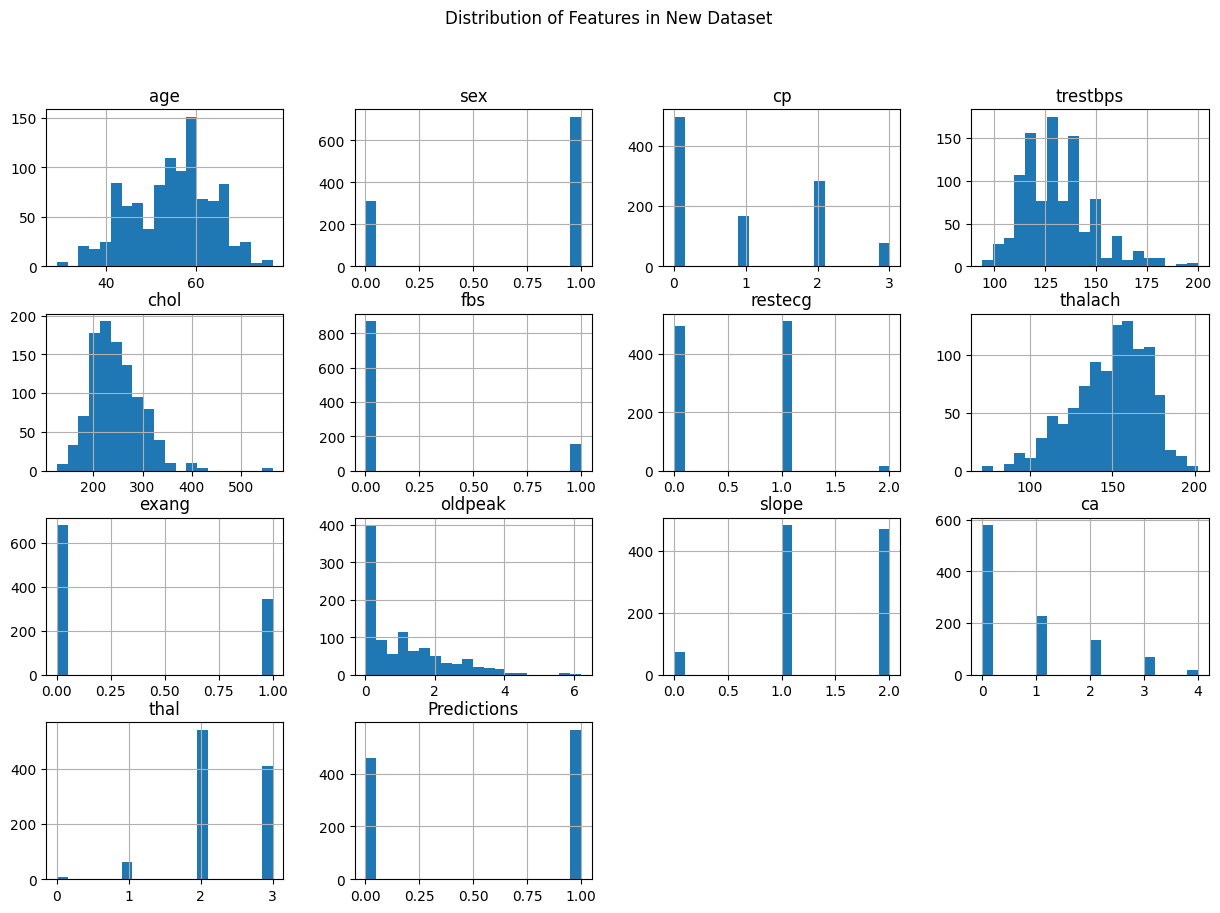

C:\Users\harshit\AppData\Local\Temp\ipykernel_2256\603622729.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predictions', data=new_data, palette="viridis")


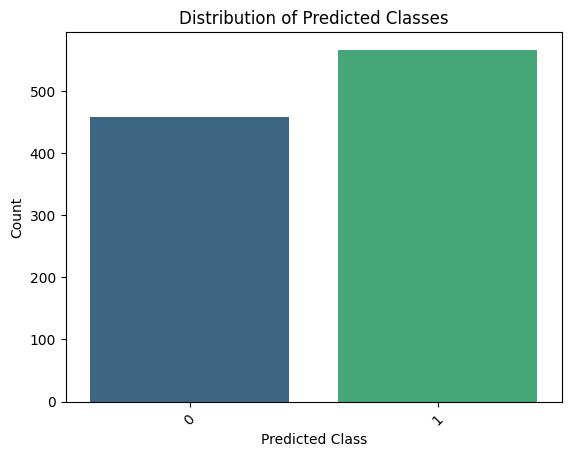

In [17]:
# Load label encoders and label mapping
label_encoders = joblib.load('label_encoders.joblib')
label_mapping = joblib.load('label_mapping.joblib')

def preprocess_new_data(df, label_encoders):
    df = df.dropna()
    
    for column, le in label_encoders.items():
        if column in df.columns:
            df[column] = le.transform(df[column])
    
    return df

# Load new data and preprocess it
new_data = pd.read_csv('heart.csv')

if 'target' in new_data.columns:
    new_data = new_data.drop(columns=['target'])

new_data = preprocess_new_data(new_data, label_encoders)

# Load the best model
best_model = load('best_model_naive_bayes.joblib')

# Make predictions on new data
predictions = best_model.predict(new_data)

# Decode the predictions
decoded_predictions = [label_mapping[p] for p in predictions]

# Print the decoded predictions
# print("Decoded Predictions:")
# print(decoded_predictions)

# Optionally, add predictions to the DataFrame and save or display
new_data['Predictions'] = decoded_predictions
print(new_data.head())

# Save the new data with predictions to a CSV file
new_data.to_csv('Predicted_data.csv', index=False)

# Plot histograms of the new data (optional)
new_data.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Features in New Dataset")
plt.show()

# Plot distribution of predicted classes
sns.countplot(x='Predictions', data=new_data, palette="viridis")
plt.title("Distribution of Predicted Classes")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate labels for readability if needed
plt.show()